# imports de bibliotecas e de database

In [25]:
# !pip install nltk
# !pip install gensim
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install wordcloud
# !pip install tensorflow

In [26]:
import re # biblioteca para expressoes regulares
import os # biblioteca sobre o sistema operacional
import nltk # biblioteca para o preprocessamento
import gensim
import random
from zipfile import ZipFile # biblioteca para arquivos zipados
import sklearn as skl
import numpy as np # biblioteca usada para trabalhar com vetores e matrizes
import unicodedata # sera usada para remover acentos dos documentos em lingua portuguesa
import pandas as pd # biblioteca usada para trabalhar com dataframes e análise de dados
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec, KeyedVectors
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from collections import defaultdict




# Download bases de dados e modelo word2vec de 100 dimensões já treinado

In [27]:
url = 'https://github.com/gazzola/corpus_readability_nlp_portuguese/archive/refs/heads/master.zip'
url2 = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s100.zip'

# especifica o local onde ficarao os arquivos
pathFiles = 'dados/'
fileName = 'corpus_readability_nlp_portuguese.zip'

# cria uma pasta onde ficarao os arquivos
if not os.path.isdir(pathFiles):
    os.mkdir(pathFiles)

# faz o download do arquivo
os.system('wget -O %s%s %s' %(pathFiles, fileName, url))
fileName2 = 'cbow_s100.zip'
os.system('wget -O %s%s %s' %(pathFiles, fileName2, url2))

print('Arquivos extraídos com sucesso!')


Arquivos extraídos com sucesso!


In [28]:
# descompacta a base de dados de notícias
z = ZipFile('dados/corpus_readability_nlp_portuguese.zip', 'r')
z.extractall('dados/')
z.close()

z = ZipFile('dados/cbow_s100.zip', 'r')
z.extractall('dados/')
z.close()

# Importação dos datasets e target

é possivel ver que os datasets não estão balanceados

In [29]:
def import_Dataset(path):

    files = os.listdir(path)

    dataset = []

    for i, file in enumerate(files):

        # abre o arquivo
        fileTexto = open(path+'/'+file, "r", encoding='utf8', errors='replace') #utf8 #cp1252

        # le o arquivo e armazena o texto dentro da variavel "texto"
        texto = fileTexto.read()

        dataset.append(texto)

    return dataset

# importa as bases de dados
dataset_Fund1 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/1_Ensino_Fundamental_I')
print('Ensino Fundamental 1 importadas com sucesso, tamanho: %d' %len(dataset_Fund1))
dataset_Fund2 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/2_Ensino_Fundamental_II')
print('Ensino Fundamental 2 importadas com sucesso, tamanho: %d' %len(dataset_Fund2))
dataset_Medio = import_Dataset('dados/corpus_readability_nlp_portuguese-master/3_Ensino_Medio')
print('Ensino Medio importadas com sucesso, tamanho: %d' %len(dataset_Medio))
dataset_Superior = import_Dataset('dados/corpus_readability_nlp_portuguese-master/4_Ensino_Superior')
print('Ensino Superior importadas com sucesso, tamanho: %d' %len(dataset_Superior))

# concatena as bases de dados
dataset = np.asarray( dataset_Fund1+dataset_Fund2+dataset_Medio+dataset_Superior)

# cria um vetor para cada classe
target_Fund1 = np.zeros( len(dataset_Fund1), dtype=int )
target_Fund2 = np.ones( len(dataset_Fund2), dtype=int )
target_Medio = np.full(len(dataset_Medio), 2)
target_Superior = np.full(len(dataset_Superior), 3)

# concateca os vetores de classe
target = np.concatenate((target_Fund1, target_Fund2, target_Medio, target_Superior))

# obtem as classes do problema
classes = np.unique(target)

print('\nQtd. textos dataset: %d' %len(dataset))
print('Qtd. textos target: %d' %len(target))


Ensino Fundamental 1 importadas com sucesso, tamanho: 297
Ensino Fundamental 2 importadas com sucesso, tamanho: 325
Ensino Medio importadas com sucesso, tamanho: 628
Ensino Superior importadas com sucesso, tamanho: 826

Qtd. textos dataset: 2076
Qtd. textos target: 2076


In [30]:
print('\nQtd. textos dataset: %d' %len(dataset))
print('Qtd. Classes: %d' %len(pd.unique(classes)))
qtype = {}
for i in pd.unique(classes):
    print('Classe: %s, Qtd: %d, Porcentagem: %.2f' %(i, len(target[target==i]), len(target[target==i])/len(target)*100))
    qtype[i] = len(target[target==i])
    


Qtd. textos dataset: 2076
Qtd. Classes: 4
Classe: 0, Qtd: 297, Porcentagem: 14.31
Classe: 1, Qtd: 325, Porcentagem: 15.66
Classe: 2, Qtd: 628, Porcentagem: 30.25
Classe: 3, Qtd: 826, Porcentagem: 39.79


# Balanceamento do Dataset
Como o dataset estava muito desbalanceado, com uma classe que representa mais de 74% e outra representando apenas 1.26%, então é necessário o balanceamento

In [31]:
#printar tipo do dataset
print(type(dataset))
#transformar em dataframe juntando com o target
df = pd.DataFrame({'text': dataset, 'target': target})

<class 'numpy.ndarray'>


In [32]:
print(df.head())

                                                text  target
0   O jovem inventor Nicephóre Niepce foi quem co...       0
1   As coisas pioraram nas cidades, porque os pré...       0
2   Você acredita que mais de 600 mil lusitanos v...       0
3   Depois de dar um duro danado, acordando muito...       0
4   Para que todas essas coisas existam, as pesso...       0


In [33]:
print(qtype)
mean = np.array(list(qtype.values())).mean()
print(mean.round())

# Funcao para deletar linhas aleatoriamente
def delete_random_rows(df, type_value, num_to_delete):
    indices = df[df['target'] == type_value].index.tolist()
    if len(indices) <= num_to_delete:
        return df.drop(index=indices)
    else:
        random_indices = random.sample(indices, num_to_delete)
        return df.drop(index=random_indices)

# Funcao para duplicar linhas aleatoriamente
def duplicate_random_rows(df, type_value, num_to_duplicate):
    indices = df[df['target'] == type_value].index.tolist()
    if len(indices) == 0:
        return df
    else:
        new_rows = df.loc[random.sample(indices, 1)]  # Sample existing row
        new_rows = pd.concat([new_rows] * num_to_create, ignore_index=True)
        return pd.concat([df, new_rows])

# Processa cada tipo de texto
for type_value in pd.unique(df['target']):
    count = qtype[type_value]
    if count > mean:
        num_to_delete = min(count - int(mean), count)
        df = delete_random_rows(df, type_value, num_to_delete)
    elif count < mean:
        num_to_create = int(mean) - count
        df = duplicate_random_rows(df, type_value, num_to_create)
        
print('\nAfter balancing:')
print('Qtd. textos dataset: %d' % len(df))
print('Qtd. Classes: %d' % len(pd.unique(df['target'])))
for i in pd.unique(df['target']):
    print('Classe: %s, Qtd: %d' % (i, len(df[df['target'] == i])))

print(df)

{0: 297, 1: 325, 2: 628, 3: 826}
519.0

After balancing:
Qtd. textos dataset: 2076
Qtd. Classes: 4
Classe: 0, Qtd: 519
Classe: 1, Qtd: 519
Classe: 2, Qtd: 519
Classe: 3, Qtd: 519
                                                  text  target
0     O jovem inventor Nicephóre Niepce foi quem co...       0
1     As coisas pioraram nas cidades, porque os pré...       0
2     Você acredita que mais de 600 mil lusitanos v...       0
3     Depois de dar um duro danado, acordando muito...       0
4     Para que todas essas coisas existam, as pesso...       0
..                                                 ...     ...
189  Drogas. As drogas psicotrópicas agem no sistem...       1
190  Drogas. As drogas psicotrópicas agem no sistem...       1
191  Drogas. As drogas psicotrópicas agem no sistem...       1
192  Drogas. As drogas psicotrópicas agem no sistem...       1
193  Drogas. As drogas psicotrópicas agem no sistem...       1

[2076 rows x 2 columns]


# Preprocessing

In [34]:
# Download stopwords corpus
nltk.download('stopwords')

# Download RSLPStemmer
nltk.download('rslp')

from nltk.stem import RSLPStemmer # para fazer a estemização em documentos da lingua portuguesa

def preprocessing_portuguese(text, stemming = False, stopwords = False):

    # Lower case
    text = text.lower()

    # remove os acentos das palavras
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

    # remove tags HTML
    regex = re.compile('<[^<>]+>')
    text = re.sub(regex, " ", text)

    # normaliza as URLs
    regex = re.compile('(http|https)://[^\s]*')
    text = re.sub(regex, "<URL>", text)

    # normaliza emails
    regex = re.compile('[^\s]+@[^\s]+')
    text = re.sub(regex, "<EMAIL>", text)

    # converte todos os caracteres não-alfanuméricos em espaço
    regex = re.compile('[^A-Za-z0-9]+')
    text = re.sub(regex, " ", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+.[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+,[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+')
    text = re.sub(regex, "NUMERO", text)


    # substitui varios espaçamentos seguidos em um só
    text = ' '.join(text.split())

    # separa o texto em palavras
    words = text.split()

    # trunca o texto para apenas 200 termos
    words = words[0:200]

    # remove stopwords
    if stopwords:
        words = text.split() # separa o texto em palavras
        words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
        text = " ".join( words )

    # aplica estemização
    if stemming:
        stemmer_method = RSLPStemmer()
        words = [ stemmer_method.stem(w) for w in words ]
        text = " ".join( words )

    # remove palavras compostas por apenas um caracter
    words = text.split() # separa o texto em palavras
    words = [ w for w in words if len(w)>1 ]
    text = " ".join( words )

    return text

class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, stemming=False, stopwords=False):
        self.stemming = stemming
        self.stopwords = stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [preprocessing_portuguese(x, self.stemming, self.stopwords) for x in X]
    

<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mathe\AppData\Local\Temp\ipykernel_21860\1791963403.py:23: SyntaxWarning: invalid escape sequence '\s'
  regex = re.compile('(http|https)://[^\s]*')
C:\Users\mathe\AppData\Local\Temp\ipykernel_21860\1791963403.py:27: SyntaxWarning: invalid escape sequence '\s'
  regex = re.compile('[^\s]+@[^\s]+')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# funções para o embedding


In [35]:
class Embedding(BaseEstimator, TransformerMixin):
    def __init__(self, pretreinado, vector_size, window, min_count ):
        self.pretreinado = pretreinado
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        
        if self.pretreinado:
            self.model = KeyedVectors.load_word2vec_format('dados/cbow_s100.txt')
        else:
            self.model = Word2Vec(sentences = X,
                          vector_size = self.vector_size,
                          window = self.window,
                          min_count = self.min_count)
        return self


    def transform(self, X, y=None):
        if self.pretreinado:
            return self.dataset2featureMatrix2(X, self.model)
        else:
            return self.dataset2featureMatrix(X, self.model)
    
    def getDocvector(self, model, doc):

        wordList = []
        for word in doc:

            try:
                vec = model.wv[word]
                wordList.append(vec)
            except:
                pass

        if len(wordList)>0:
            vetorMedio = np.mean( wordList, axis=0 )
        else:
            vetorMedio = np.zeros( model.vector_size )

        return vetorMedio

    def dataset2featureMatrix(self, dataset, embeddingModel):

        X_embedding = []
        for doc in dataset:
            vec = self.getDocvector(embeddingModel, doc)
            X_embedding.append(vec)

        X_embedding = np.array(X_embedding)

        return X_embedding
    

    def getDocvector2(self, model, doc):
        wordList2 = []
        for word in doc:
            try:
                vec = model[word]
                wordList2.append(vec)
            except:
                pass
        if len(wordList2)>0:
            vetorMedio = np.mean( wordList2, axis=0 )
        else:        
            vetorMedio = np.zeros( model.vector_size )

        return vetorMedio

    def dataset2featureMatrix2(self, dataset, embeddingModel):

        word2v = []
        for doc in dataset:
            vec = self.getDocvector2(embeddingModel, doc)
            word2v.append(vec)

        word2v = np.array(word2v)

        return word2v

# nuvem de palavra do dataset

é  possivel observar que precisa do preprocessamento

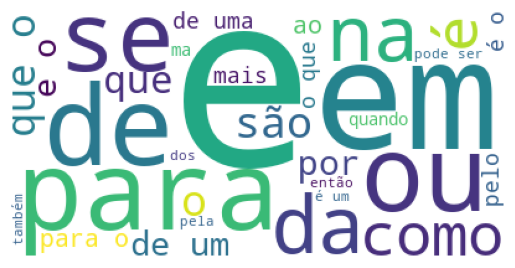

In [36]:
import matplotlib.pyplot as plt

from wordcloud import WordCloud

wc = WordCloud(min_font_size = 10, max_font_size = 200, 
               background_color = "white", relative_scaling=0.5)

# Adicione o texto à nuvem de palavras
wc.generate(" ".join(dataset))

# Plote a nuvem de palavras
plt.imshow(wc)
plt.axis("off")
plt.show()

# Divisão do dataset 


In [37]:
dataset = df['text']
target = df['target']

display(dataset.head())
display(target.head())

0     O jovem inventor Nicephóre Niepce foi quem co...
1     As coisas pioraram nas cidades, porque os pré...
2     Você acredita que mais de 600 mil lusitanos v...
3     Depois de dar um duro danado, acordando muito...
4     Para que todas essas coisas existam, as pesso...
Name: text, dtype: object

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataset,  # Dados com os títulos e textos
    target,   # Classes correspondentes
    test_size=0.2,  # Porcentagem dos dados a serem usados como conjunto de teste
    random_state=42  # Semente para a geração de números aleatórios para reprodutibilidade
)
# display(X_train.head())
# display(y_train.head())
# display(X_test.head())
# display(y_test.head())
print(X_train.shape)
print(X_test.shape)
print('\nQtd. textos dataset: %d' %len(dataset))
print('\nQtd. textos dataset: %d' %len(X_train))
print('\nQtd. textos dataset: %d' %len(X_test))

(1660,)
(416,)

Qtd. textos dataset: 2076

Qtd. textos dataset: 1660

Qtd. textos dataset: 416


# definição dos pipeline e execução do Grid Search

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


class MLP(BaseEstimator, TransformerMixin):
    def __init__(self, hidden_layer_size = [200,10],learning_rate=0.001, solver = 'adam', output_layer_size = 4, l2 = 0.001, dropout = 0, epochs = 50, activation = 'relu'):

        self.model = None
        self.output_layer_size = output_layer_size
        self.solver = solver
        self.hidden_layer_size = hidden_layer_size
        self.dropout = dropout
        self.epochs = epochs
        self.l2 = l2
        self.activation = activation
        self.learning_rate = learning_rate
        # regularizacao
        self.regularizacao = tf.keras.regularizers.L2(self.l2)
        # Configura o modelo de rede neural artificial
        self.model = Sequential()

    def fit(self, X, y):
        self.input_layer_size = X.shape[1]
        self.input_shape = (self.input_layer_size,)
        self.model.add(tf.keras.Input(shape=(self.input_layer_size,)))
        for i in self.hidden_layer_size:

            self.model.add(Dense(i,
                            activity_regularizer = self.regularizacao,
                            activation=self.activation)
                    )

        if (self.dropout > 0):
            self.model.add(Dropout(self.dropout))

        self.model.add(Dense(self.output_layer_size, activation='softmax'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


        self.history = self.model.fit(X, y, epochs = self.epochs, validation_split=0.3, verbose = 0)
        # print(self.model.summary())


        return self.history


    def transform(self, X, y=None):
        return self


    def predict(self, X_test):
        pred = self.model.predict(X_test)
        # self.model = Sequential()
        return pred

    def clean(self):
        self.model = Sequential()

    def get_history(self):
        return self.history


## Com todos os parametros


Método:  MLP Word2Vec
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
Melhor Acurácia:  0.65625
Melhor Macro F1:  0.6487107311115881
Melhor precisão:  0.6567853957636566
Melhor revocação:  0.6576894102453723
Melhor AUC:  0.8788450185356741
Melhores Parâmetros:  {'preprocessing__stopwords': True, 'preprocessing__stemming': True, 'clf__output_layer_size': 4, 'clf__learning_rate': 0.001, 'clf__l2': 0.01, 'clf__hidden_layer_size': [200, 100, 50, 10], 'clf__epochs': 20, 'clf__dropout': 0.001, 'clf__activation': 'relu'}


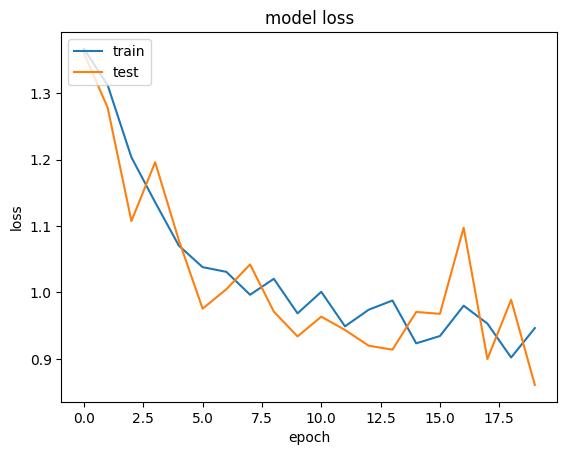


Método:  MLP Word2Vec(pretreinado)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
Melhor Acurácia:  0.5216346153846154
Melhor Macro F1:  0.5314785896942061
Melhor precisão:  0.55140573089701
Melhor revocação:  0.5219489883770986
Melhor AUC:  0.80747372784137
Melhores Parâmetros:  {'preprocessing__stopwords': True, 'preprocessing__stemming': True, 'clf__output_layer_size': 4, 'clf__learning_rate': 0.001, 'clf__l2': 0.001, 'clf__hidden_layer_size': [200, 100, 50, 10], 'clf__epochs': 10, 'clf__dropout': 0.001, 'clf__activation': 'relu'}


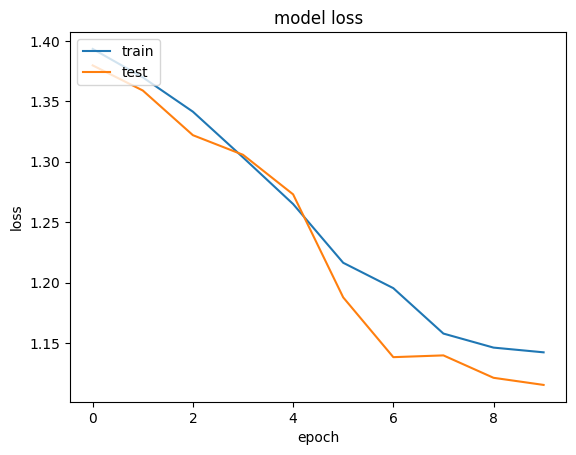

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterSampler
pipelines = [

    ('MLP Word2Vec', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado=False, vector_size=200, window=3,min_count=1)),
        ('clf', MLP()),
    ])),
    ('MLP Word2Vec(pretreinado)', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado=True, vector_size=200, window=3,min_count=1)),
        ('clf', MLP()),
    ]))
]

preprocessed_data = defaultdict(dict)
# Definindo a grade de parâmetros
parameters = {
    'preprocessing__stemming': [ False, True],
    'preprocessing__stopwords': [ False, True],
    'clf__hidden_layer_size':[[200, 100, 50, 10], [200, 100, 10]],
    'clf__dropout':[0.01, 0.001],
    'clf__activation':['relu'], #camadas intermediarias, a ultima é softmax
    'clf__epochs':[10,20],
    'clf__l2':[0.001, 0.01],
    'clf__output_layer_size':[4],
    'clf__learning_rate':[0.001, 0.01],
}

param_distributions = ParameterSampler(parameters, n_iter=5)


best_auc_pipeline = 0
best_pipeline = None
preprocessed_X_train = None
for name, pipeline in pipelines:
    best_accuracy = 0
    best_auc = 0
    best_params = None
    print("\nMétodo: ", name)

    for params in param_distributions:
        
# Verifica se os dados pré-processados já existem no dicionário
        
        pipeline.set_params(**params)
        # Ajusta o pipeline aos dados pré-processados
        pipeline.fit(X_train, y_train)
        history = pipeline.named_steps['clf'].get_history()
        Y_pred = pipeline.predict(X_test )
        y_pred = np.argmax(Y_pred, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro'  )
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, Y_pred, average='macro', multi_class='ovr')
        pipeline.named_steps['clf'].clean()
        tf.keras.backend.clear_session()
        # Se o auc for melhor que o melhor auc até agora, atualiza o melhor auc e os melhores parâmetros
        if auc > best_auc:
            best_accuracy = accuracy
            best_macro = macro_f1
            best_precision = precision
            best_recall = recall
            best_params = params
            best_pipeline = pipeline
            best_history = history
            best_auc = auc

    
    if best_auc > best_auc_pipeline:
        best_auc_pipeline = best_auc
        best_pipeline = pipeline
    print("Melhor Acurácia: ", best_accuracy)
    print("Melhor Macro F1: ", best_macro)
    print("Melhor precisão: ", best_precision)
    print("Melhor revocação: ", best_recall)
    print("Melhor AUC: ", best_auc)
    print("Melhores Parâmetros: ", best_params)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()